In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


## 학습 데이터 준비

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
train_data = pd.read_csv('data/train.csv')

In [ ]:
# train_data = train_data.sort_values('content_id')

In [ ]:
import json

with open('data/brand_dict.json', 'r') as f:
    brand_dict = json.load(f)

with open('data/cat_3_dict.json', 'r') as f:
    cat_3_dict = json.load(f)

with open('data/place_dict.json', 'r') as f:
    place_dict = json.load(f)

with open('data/train_img2vec.json', 'r') as f:
    train_img2vec = json.load(f)

with open('data/train_text2vec_no.json', 'r') as f:
    train_text2vec = json.load(f)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import log_loss, roc_auc_score

In [ ]:
sparse_features = [
    'viewer_gender',  
    'content_used',
    'content_cat_1',
    'content_delivery_fee',
    'content_b_pay'
    ]
    
dense_features  = [
    'bid_price', 
    'content_price',
    'content_comment_count',     
    'content_views',       
    'content_likes',
    'adv_item_count',
    'adv_follower_count', 
    'adv_review_count',
    'viewer_age',
    'viewer_following_count',
    'viewer_pay_count',
    "viewer_parcel_post_count",
    'viewer_transfer_count',
    'viewer_chat_count', 
    ]

features = sparse_features + dense_features

In [ ]:
# 수동 라벨인코딩
cat_label = {}
for i, cat in enumerate(train_data['content_cat_1'].unique()):
    cat_label[cat] = i

train_data['content_cat_1'] = train_data['content_cat_1'].apply(lambda x: cat_label[x])
train_data['content_delivery_fee'] = train_data['content_delivery_fee'].apply(lambda x: 1 if x=='배송비포함' else 0)

# 스케일링, scaler 남겨두기
scaler = StandardScaler()
# scaler = RobustScaler()
train_data[dense_features] = scaler.fit_transform(train_data[dense_features])

## DeepFM - Image, Text

In [ ]:
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names, VarLenSparseFeat
from deepctr_torch.models import *
from deepctr_torch.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data[features + ['content_id']], train_data['label'], test_size=0.2, random_state=47)

In [ ]:
# input data 생성
fixlen_feature_columns = [SparseFeat(feat, train_data[feat].nunique())
                            for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]
# 학습에 사용할 feature 지정
feature_names = get_feature_names(fixlen_feature_columns)
feature_columns = fixlen_feature_columns + [DenseFeat('image_vec', 512)] + [DenseFeat('text_vec', 100)]

# train data 생성
# 정형 데이터
train_model_input = {name: X_train[name] for name in feature_names}
# image vector input
train_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_train['content_id']])}
# text vector input
train_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_train['content_id']])}
# 정형 데이터 + 이미지 + 텍스트
train_model_input = {**train_model_input, **train_image_model_input, **train_text_model_input}

# test data 생성
test_model_input = {name: X_test[name] for name in feature_names}
test_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_test['content_id']])}
test_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_test['content_id']])}
test_model_input = {**test_model_input, **test_image_model_input, **test_text_model_input}

In [ ]:
# 평균 CTR 계산
average_ctr = train_data['label'].mean()

# RIG 계산 함수
def get_rig(train_y, test_y, pred, avg_ctr):
    prior = log_loss(train_y, [avg_ctr]*len(train_y))

    classifier = log_loss(test_y, pred)

    rig = (prior - classifier) / prior
    return rig

# 평가
def evaluate(pred):
    print("")
    print("test LogLoss", round(log_loss(y_test, pred), 4))
    print("test AUC", round(roc_auc_score(y_test, pred), 4))
    print("test RIG", round(get_rig(y_train, y_test, pred, average_ctr), 4))

## DeepFM 학습

- Overfitting을 방지하기 위해 dropout 및 5-fold CV, Early Stopping 진행

In [ ]:
# GPU 설정
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512,256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)
# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )
# Early Stoppin 적용
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='min')
# 모델 학습
hist_r = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=512, 
                     epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

cuda ready...
cuda:0
Train on 470844 samples, validate on 117711 samples, 920 steps per epoch
Epoch 1/50
11s - loss:  0.1390 - binary_crossentropy:  0.1390 - auc:  0.6837 - val_binary_crossentropy:  0.1311 - val_auc:  0.7031
Epoch 2/50
11s - loss:  0.1346 - binary_crossentropy:  0.1346 - auc:  0.7011 - val_binary_crossentropy:  0.1340 - val_auc:  0.7020
Epoch 3/50
11s - loss:  0.1341 - binary_crossentropy:  0.1341 - auc:  0.7087 - val_binary_crossentropy:  0.1327 - val_auc:  0.7099
Epoch 4/50
11s - loss:  0.1336 - binary_crossentropy:  0.1336 - auc:  0.7150 - val_binary_crossentropy:  0.1324 - val_auc:  0.7022
Epoch 5/50
11s - loss:  0.1332 - binary_crossentropy:  0.1332 - auc:  0.7185 - val_binary_crossentropy:  0.1298 - val_auc:  0.7192
Epoch 6/50
11s - loss:  0.1327 - binary_crossentropy:  0.1327 - auc:  0.7220 - val_binary_crossentropy:  0.1300 - val_auc:  0.7193
Epoch 7/50
11s - loss:  0.1326 - binary_crossentropy:  0.1326 - auc:  0.7241 - val_binary_crossentropy:  0.1297 - val_au

### Test set으로 평가

In [ ]:
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1322
test AUC 0.7288
test RIG 0.0663


### Cross Validation 시각화

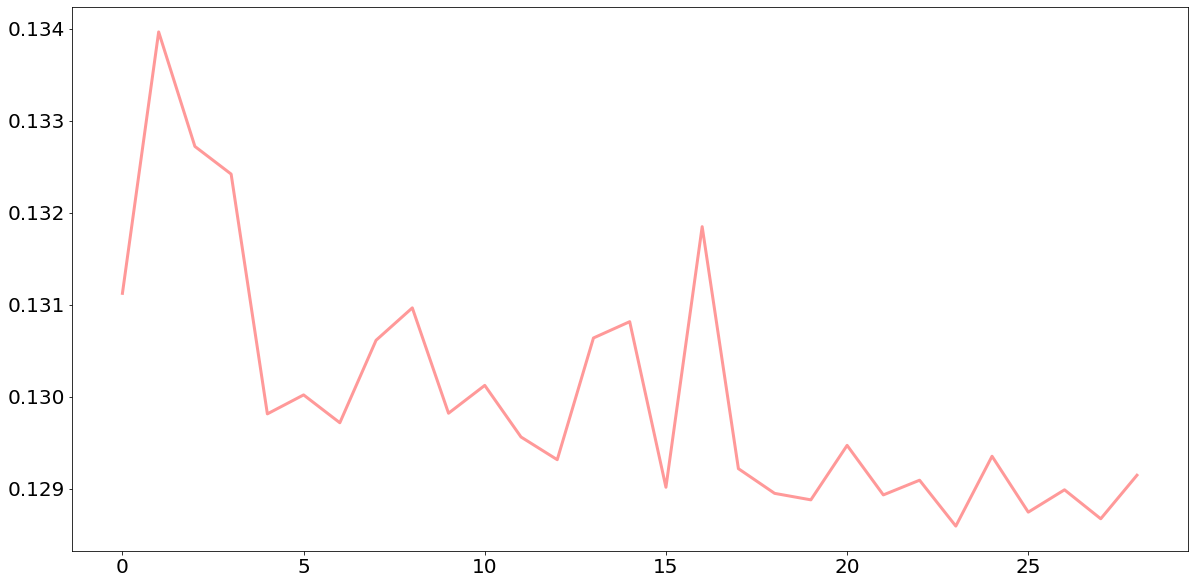

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.plot(hist_r.history['val_binary_crossentropy'], "#ff9999", linewidth=3)

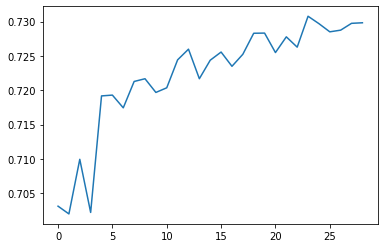

In [ ]:
plt.plot(hist.history['val_auc'])

## LightGBM 학습 - image, text vector

### 각 게시글 id별로 embedding vector를 LightGBM input 형태에 맞게 입력

In [ ]:
from tqdm.notebook import tqdm

for i in tqdm(range(512)):
    X_train[f'img_vec_{i}'] = X_train['content_id'].apply(lambda x: train_img2vec[str(x)][i])
    X_test[f'img_vec_{i}'] = X_test['content_id'].apply(lambda x: train_img2vec[str(x)][i])

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
for j in tqdm(range(100)):
    X_train[f'txt_vec_{j}'] = X_train['content_id'].apply(lambda x: train_text2vec[str(x)][j])
    X_test[f'txt_vec_{j}'] = X_test['content_id'].apply(lambda x: train_text2vec[str(x)][j])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import lightgbm as lgb

### LightGBM 학습

In [ ]:
model_lgb = lgb.LGBMClassifier(n_estimators=200, 
                           random_state=47, 
                           learning_rate=0.1,
                           boosting_type='gbdt', 
                           num_leaves=255, 
                           max_depth=20, 
                           min_data_in_leaf=200, 
                           zero_as_missing=True,
                           objective='binary')
model_lgb.fit(X_train.drop('content_id', axis=1), y_train)

pred_lgb = model_lgb.predict_proba(X_test.drop('content_id', axis=1))[:,1]
evaluate(pred_lgb)


test LogLoss 0.1271
test AUC 0.7671
test RIG 0.102


feature importance

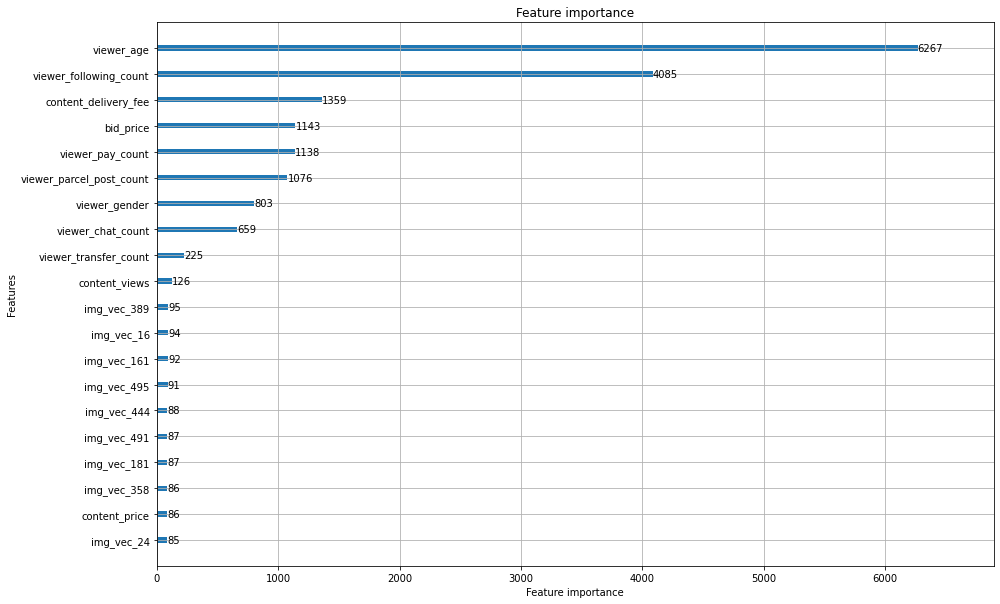

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model_lgb, ax=ax, max_num_features=20)

## Finalize

- 확정된 파라미터를 이용해 train, test data 모두 사용해서 최종 학습
- Test set은 없지만, Cross Validation을 통해 학습이 잘 되는지 확인

In [ ]:
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

X_final = X_train.append(X_test)
y_final = y_train.append(y_test)
final_model_input = {name: X_final[name] for name in feature_names}

final_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_final['content_id']])}
final_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_final['content_id']])}
final_model_input = {**final_model_input, **final_image_model_input, **final_text_model_input}


# 모델 정의
model_final = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512, 256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)

# optimizer, loss 설정
model_final.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_auc', min_delta=0, verbose=2, patience=5, mode='max')
hist_f = model_final.fit(x = final_model_input, y = y_final.values , batch_size=512, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

cuda ready...
cuda:0
Train on 588555 samples, validate on 147139 samples, 1150 steps per epoch
Epoch 1/50
19s - loss:  0.1377 - binary_crossentropy:  0.1377 - auc:  0.6861 - val_binary_crossentropy:  0.1337 - val_auc:  0.7038
Epoch 2/50
19s - loss:  0.1338 - binary_crossentropy:  0.1338 - auc:  0.7044 - val_binary_crossentropy:  0.1359 - val_auc:  0.7066
Epoch 3/50
19s - loss:  0.1334 - binary_crossentropy:  0.1335 - auc:  0.7112 - val_binary_crossentropy:  0.1338 - val_auc:  0.7071
Epoch 4/50
19s - loss:  0.1331 - binary_crossentropy:  0.1331 - auc:  0.7164 - val_binary_crossentropy:  0.1343 - val_auc:  0.7110
Epoch 5/50
19s - loss:  0.1325 - binary_crossentropy:  0.1325 - auc:  0.7185 - val_binary_crossentropy:  0.1335 - val_auc:  0.7112
Epoch 6/50
19s - loss:  0.1325 - binary_crossentropy:  0.1325 - auc:  0.7203 - val_binary_crossentropy:  0.1338 - val_auc:  0.7105
Epoch 7/50
19s - loss:  0.1320 - binary_crossentropy:  0.1320 - auc:  0.7239 - val_binary_crossentropy:  0.1325 - val_a

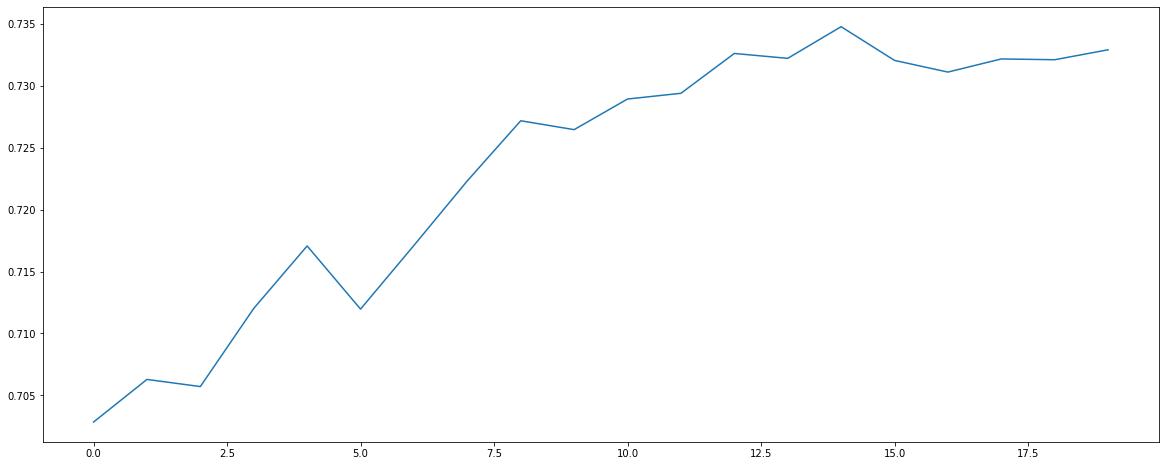

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(hist_f.history['val_auc'])

In [ ]:
import plotly.express as px
fig = px.line(y = hist_f.history['val_auc'], title='Loss')
fig.update_layout(plot_bgcolor='white')
fig['data'][0]['line']['color']="#ff9999"
fig.show()

### 학습된 모델 저장

In [ ]:
# import torch
torch.save(model_final, 'model/deepfm_final.h5')